# Deep Learning
## Assignment 5
The goal of this assignment is to train a Word2Vec CBOW model over Text8 data.

Continuous Bag-Of-Words (CBOW) is conceptually similar to a reversed skip-gram model. Instead of training the model on what the context (i.e. words around the input) should be to a given input word, we train the model on what the output (i.e. word in the middle) should be to a given context.

References :
 http://www.thushv.com/natural_language_processing/word2vec-part-2-nlp-with-deep-learning-with-tensorflow-cbow/
 
Skip-gram: works well with small amount of the training data, represents well even rare words or phrases.
CBOW: several times faster to train than the skip-gram, slightly better accuracy for the frequent words

In skip-gram, you're calculating the context word(s) from the word at the current position in the sentence; you're "skipping" the current word (and potentially a bit of the context) in your calculation. The result can be more than one word (but not if your context window is just one word long).

In CBOW, you're calculating the current word from the context word(s), so you will only ever have one word as a result.

CBOW is learning to predict the word by the context. Or maximize the probability of the target word by looking at the context. And this happens to be a problem for rare words. For example, given the context yesterday was really [...] day CBOW model will tell you that most probably the word is beautiful or nice. Words like delightful will get much less attention of the model, because it is designed to predict the most probable word. This word will be smoothed over a lot of examples with more frequent words.

Skip-gram is designed to predict the context. Given the word delightful it must understand it and tell us, that there is huge probability, the context is yesterday was really [...] day, or some other relevant context. With skip-gram the word delightful will not try to compete with word beautiful but instead, delightful+context pairs will be treated as new observations.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token. (UNK - Unknown Words)

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [5]:
# Printing some sample data
print(data[:20])
print(count[:20])
print(dictionary.items()[:20])
print(reverse_dictionary.items()[:20])

[5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156, 128, 742, 477, 10572, 134, 1, 27549, 2, 1, 103]
[['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430), ('two', 192644), ('is', 183153), ('as', 131815), ('eight', 125285), ('for', 118445), ('s', 116710), ('five', 115789), ('three', 114775), ('was', 112807), ('by', 111831)]
[('fawn', 45848), ('homomorphism', 9648), ('nordisk', 39343), ('nunnery', 36075), ('chthonic', 33554), ('sowell', 40562), ('sonja', 38175), ('showa', 32906), ('woods', 6263), ('hsv', 44222), ('spiders', 14623), ('hanging', 8021), ('woody', 11150), ('comically', 38935), ('localized', 16716), ('schlegel', 39763), ('sevens', 47931), ('canes', 30965), ('sprague', 19496), ('chatter', 45028)]
[(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in'), (6, 'a'), (7, 'to'), (8, 'zero'), (9, 'nine'), (10, 'two'), (11, 'is'), (12, 'as'), (13, 'eight'), (14, '

Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

def generate_batch(batch_size, skip_window):
  # skip window is the amount of words we're looking at from each side of a given word 
  # creates a single batch
  global data_index
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) 
  # e.g if skip_window = 2 then span = 5
  # span is the length of the whole frame we are considering for a single word (left + word + right)
  # skip_window is the length of one side
  
  # queue which add and pop at the end  
  buffer = collections.deque(maxlen=span)
    
  #get words starting from index 0 to span  
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  # num_skips => # of times we select a random word within the span?
  # batch_size (8) and num_skips (2) (4 times)
  # batch_size (8) and num_skips (1) (8 times)  
  for i in range(batch_size):
    buffer_list = list(buffer)
    labels[i, 0] = buffer_list.pop(skip_window)
    batch[i] = buffer_list
    # iterate to the next buffer
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for skip_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=4, skip_window=skip_window)
    print('\nwith skip_window = %d:' % (skip_window))  
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])  
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with skip_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
    labels: ['originated', 'as', 'a', 'term']

with skip_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
    labels: ['as', 'a', 'term', 'of']


Train a skip-gram model.

In [7]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 2 # How many words to consider left and right.
num_skips = 4 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 1000 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, skip_window * 2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights = softmax_weights, biases = softmax_biases, inputs = tf.reduce_sum(embed, 1), 
                               labels = train_labels, num_sampled= num_sampled, num_classes= vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [8]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.137120
Nearest to self: perceptions, interface, albinism, glace, frightening, nakajima, hammer, mbit,
Nearest to beginning: glued, backgammon, hein, cz, clarendon, repelled, video, spurring,
Nearest to best: probability, steroids, performed, palaces, maradona, qadhafi, vanishes, dervish,
Nearest to cause: squire, mutt, representable, rosy, kingfishers, thereby, delicacy, eclectic,
Nearest to forms: ffts, die, persephone, emulating, ringing, accords, castilian, designates,
Nearest to among: nicola, clockless, cantatas, niebuhr, gneisenau, warden, immigration, synchronicity,
Nearest to changed: inescapable, progressed, subcultural, handbook, aggressors, constant, ostrava, tetrahedron,
Nearest to word: contrasts, gnu, resorting, bilinear, theorize, ejaculation, pockets, complained,
Nearest to development: reflectors, neighbourhoods, cumann, fountain, discriminating, orthogonal, ambience, btr,
Nearest to services: whistling, cogent, analysing, opal, ha

Average loss at step 42000: 3.207686
Average loss at step 44000: 3.141986
Average loss at step 46000: 3.143532
Average loss at step 48000: 3.053916
Average loss at step 50000: 3.054808
Nearest to self: copyrighted, moray, valet, csp, alans, axon, nand, andrey,
Nearest to beginning: arrived, end, battle, removal, least, glued, mirc, middle,
Nearest to best: earliest, first, greatest, better, bedouin, confessor, aeschylus, subpage,
Nearest to cause: strachey, occur, bring, flow, result, disease, gecko, loss,
Nearest to forms: types, parts, elements, ways, examples, aspects, versions, stewardship,
Nearest to among: including, amongst, while, throughout, however, with, vince, against,
Nearest to changed: developed, given, shown, increased, introduced, continued, stated, erected,
Nearest to word: term, name, words, language, reason, example, alphabet, hone,
Nearest to development: growth, jared, performance, research, profession, descent, technology, laboratories,
Nearest to services: soloi

In [9]:
# Printing Embeddings (They are all Normalized)
print(final_embeddings[0])
print(np.sum(np.square(final_embeddings[0])))

[ 0.20969677 -0.0995643  -0.08115204  0.02636736 -0.06062403  0.029928
 -0.06633912 -0.00104288 -0.04791704  0.03886715 -0.08506599  0.14849339
 -0.0389503   0.00088402  0.0789289  -0.1375984   0.01451704  0.01377609
 -0.11638993 -0.02369793  0.08557943  0.05542488  0.0556914   0.14430574
 -0.15019186  0.02819679 -0.10688339 -0.05652772  0.08727412 -0.04198151
  0.03764377 -0.10241836 -0.07807684 -0.02233607 -0.04732079  0.05407755
 -0.03601359  0.07619023 -0.00782523  0.10322203  0.04342692  0.1379187
 -0.10209256  0.07541366 -0.06852317  0.13703294  0.03064066 -0.06990487
 -0.01715378 -0.08069704  0.07818571 -0.0141713  -0.01107528 -0.04225896
 -0.06967285 -0.11269948  0.09823778  0.00951729  0.06232495  0.10840479
  0.05978485  0.06910846 -0.05119228 -0.08695638  0.11943432  0.13228111
  0.00278037  0.14862855 -0.12851213 -0.1072882   0.09828401  0.02708467
 -0.05779122 -0.23605582  0.08278482 -0.04080535 -0.11224427 -0.01567278
 -0.07504006 -0.11852523  0.01230333  0.11112113 -0.07

In [12]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

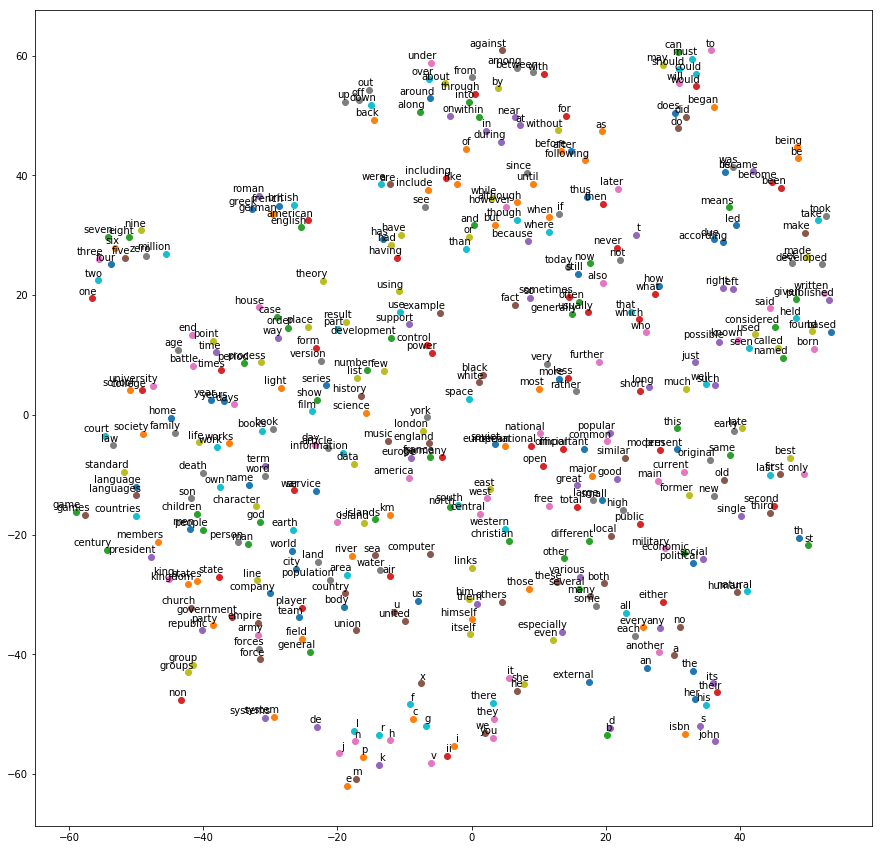

In [11]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

If you observe the scatter plot above, we see that the words that share common contexts in the corpus are located in close proximity to one another in the space.
Ex : one, two, three...; does,did,do...; you, we, they...
      